In [1]:
from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.nested_sampling import NestedSampler
import numpyro.distributions as dist

In [2]:
ndims = 2
data_mu = jnp.ones(ndims)
data_cov = jnp.diag(jnp.ones(ndims)) ** 2
data_cov = jnp.where(data_cov == 0., 0.95, data_cov)

Number of weighted samples: 2291
Effective sample size: 1103.0


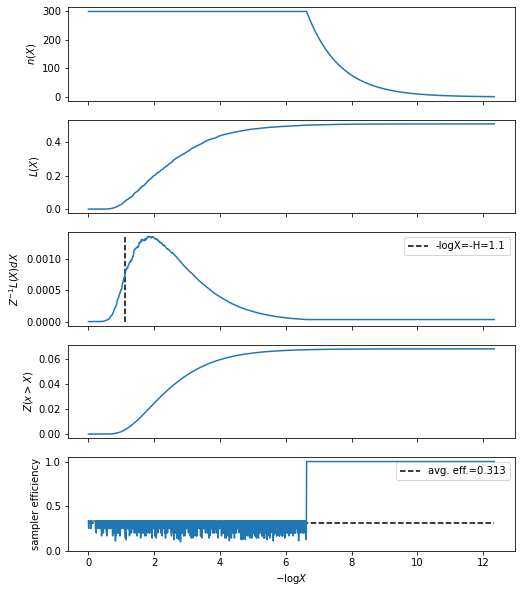

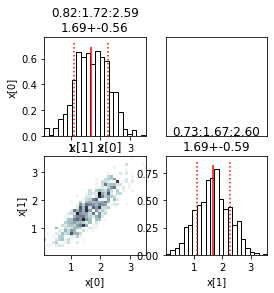

In [3]:
def model():
    x = numpyro.sample("x", dist.Normal(2, 1).expand([ndims]))
    numpyro.sample("obs", dist.MultivariateNormal(x, data_cov), obs=data_mu)


ns = NestedSampler(model, num_live_points=300)
ns.run(random.PRNGKey(0))
ns.diagnostics()